<a href="https://colab.research.google.com/github/DATA601-CustSegment-Nov2025-to-Feb2026/New-CustSegment-Project/blob/Benjamin_Clustering/Customer_Segmentation_(Clustering_Algorithms_Benjamin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Load Datasets

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from functools import reduce
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths to the household profile dataset stored in Google Drive
household_profile_path = '/content/drive/MyDrive/0. Colab Notebooks (DATA 60X Project)/2. Preprocessed Datasets/customer_segmentation_after_preprocessing.csv'

# Read the dataset from its CSV file
household_profile_df = pd.read_csv(household_profile_path, low_memory=False)

# Create a copy to inverse the scaling, transformation and encoding
inverse_household_profile_df = household_profile_df.copy()

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)

# Display first 5 rows of the dataset
household_profile_df.head(5)

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion
0,1,2.0,-0.333333,0.0,0.0,0.489861,-0.621099,-0.087203,-0.549338,-0.459021,0.459021,1.583771,1.120307,-1.120307,-0.129775,-0.138096,0.078206,1.292766,0.634063,0.139677,1.560290,-3.865000,0.246488,0.393576,-0.913541,0.291299,0.212894,-0.603169,1.501936,-1.501936,0.041404,1.277385,0.053773,0.895717,0.950963,0.090203,0.724057,0.511598,0.932404,-3.621881
1,7,0.0,0.000000,0.0,0.0,0.000000,-1.136685,-0.358394,-0.737420,-0.420944,0.420944,0.823167,0.572751,-0.572751,0.008514,-0.613512,0.083732,0.365092,0.273008,-0.139884,-0.667486,1.044168,-2.080063,1.423309,0.636160,1.437844,-1.338296,-0.243626,-0.803241,0.803241,-0.068422,0.250714,-0.057319,0.367726,0.847179,0.043339,0.057966,-0.238082,0.445438,-0.495107
2,8,-2.0,-0.666667,0.5,1.0,0.489861,-0.263006,0.192638,0.216292,0.127897,-0.127897,0.053112,0.298768,-0.298768,-0.147119,-0.164463,0.093260,-0.190946,0.131973,-0.212785,0.385384,0.814867,0.139347,-0.333988,0.179627,-0.305296,-0.017878,0.288159,0.309949,-0.309949,1.189880,-0.578625,-0.289342,-0.635065,-0.699947,0.196379,-0.616372,-0.611474,-0.754490,-0.268544
3,13,-2.0,0.333333,1.0,2.0,0.000000,0.815617,1.220412,0.796188,0.198222,-0.198222,1.662848,1.516420,-1.516420,-0.183852,-0.101691,0.103422,-0.828289,-0.569294,0.782034,-0.353158,-0.313182,0.736321,-0.196075,-0.748220,-0.406573,0.903794,-0.558864,-0.181600,0.181600,-0.129866,-0.573550,-0.119470,0.077653,0.626571,0.156368,-0.418512,1.215299,-0.426007,-0.049511
4,16,0.0,0.000000,-0.5,0.0,1.192513,-0.448174,-1.235709,-1.055914,-1.273896,1.273896,-0.300252,-0.607878,0.607878,0.115384,-0.968430,0.085717,1.146129,0.813866,0.126961,1.618363,-3.908189,4.387796,12.971305,-22.672249,13.327921,5.991053,-20.844276,0.492382,-0.492382,0.152564,2.071352,0.166213,1.415026,1.086591,-0.864491,1.165722,1.238202,1.401472,-3.320718


In [5]:
# Display first 5 rows of the dataset
household_profile_df[['recency', 'frequency', 'monetary']].head()

,recency,frequency,monetary
0,0.489861,-0.621099,-0.087203
1,0.000000,-1.136685,-0.358394
2,0.489861,-0.263006,0.192638
3,0.000000,0.815617,1.220412
4,1.192513,-0.448174,-1.235709


# Inverse Scaling, Transformation, and Encoding

In [6]:
# Set the location of the fitted objects
save_dir = '/content/drive/MyDrive/0. Colab Notebooks (DATA 60X Project)/2. Preprocessed Datasets/'

# Load the previously fitted objects
robust_scaler = joblib.load(f'{save_dir}/robust_scaler.pkl')
yeo_johnson_transformation = joblib.load(f'{save_dir}/yeo_johnson_transformation.pkl')

In [7]:
# Drop household_key because it is just an identifier
inverse_robust_scale_cols = inverse_household_profile_df.drop(
    columns=['household_key']
)

# Apply the fitted RobustScaler to reverse the scaling for all selected columns
inverse_robust_scale = robust_scaler.inverse_transform(inverse_robust_scale_cols )

# Convert the inverse-transformed array back into a new dataframe: 'inverse_household_profile_df'
inverse_household_profile_df = pd.DataFrame(
    inverse_robust_scale,
    columns=inverse_robust_scale_cols.columns,
    index=household_profile_df.index
)

# Add 'household_key' back to the 'inverse_household_profile_df'
inverse_household_profile_df['household_key'] = household_profile_df['household_key'].values

# Move household_key to the first column of the 'inverse_household_profile_df'
inverse_household_profile_df = inverse_household_profile_df[
    ['household_key'] + inverse_robust_scale_cols.columns.tolist()
]
# Display first 5 rows of the dataset
inverse_household_profile_df.head()

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion
0,1,5.0,3.0,1.0,0.0,1.417809,3.293642,11.224266,0.229628,-0.121615,0.121615,0.004519,-1.363680,1.363680,0.620271,-0.030580,-0.589691,5.841657,4.048005,-7.483846,5.078030,-7.483846,-0.633739,1.529236,-0.895497,1.568759,-1.156866,-0.411894,1.007944,-1.007944,-7.403495,3.702803,-7.403495,5.994899,4.204895,-1.042129,3.676370,1.665921,4.007727,-7.403495
1,7,3.0,4.0,1.0,0.0,0.949495,3.093050,10.804470,0.220551,-0.112447,0.112447,0.002695,-1.921118,1.921118,1.177101,-0.625152,-0.551949,3.825838,3.332578,-9.375729,-0.080454,2.297768,-1.497176,1.932442,-0.435266,1.998426,-1.709906,-0.288520,0.200142,-0.200142,-7.981876,2.387912,-7.981876,5.395766,4.085986,-1.325660,2.817475,0.466100,3.461832,-1.325660
2,8,1.0,2.0,2.0,1.0,1.417809,3.432961,11.657452,0.266581,0.019709,-0.019709,0.000848,-2.200046,2.200046,0.550434,-0.063555,-0.486878,2.617577,3.053119,-9.869078,2.357500,1.840882,-0.673501,1.244348,-0.570847,1.345186,-1.239142,-0.106044,0.590237,-0.590237,-1.355270,1.325752,-9.189871,4.257858,2.313407,-0.399759,1.947947,-0.131495,2.116696,-0.885266
3,13,1.0,5.0,3.0,2.0,0.949495,3.852607,13.248418,0.294569,0.036643,-0.036643,0.004709,-0.960418,0.960418,0.402524,0.014948,-0.417472,1.232640,1.663564,-3.136808,0.647382,-0.406778,-0.451950,1.298350,-0.846400,1.307233,-0.910542,-0.396691,0.417983,-0.417983,-8.305458,1.332251,-8.305458,5.066608,3.833231,-0.641830,2.203079,2.792157,2.484930,-0.459509
4,16,3.0,4.0,0.0,0.0,2.089554,3.360920,9.446411,0.205179,-0.317830,0.317830,0.000000,-3.123053,3.123053,1.607420,-1.069024,-0.538396,5.523018,4.404284,-7.569901,5.212500,-7.569901,0.903198,6.454218,-7.357416,6.454218,0.903198,-7.357416,0.654166,-0.654166,-6.818094,4.719661,-6.818094,6.584180,4.360287,-6.818094,4.245877,2.828811,4.533559,-6.818094


In [8]:
# Columns to inverse Yeo-Johnson transformation
columns_to_inverse_yeo_johnson_transformation = [
    'recency',
    'frequency',
    'monetary',
    'retail_discount_mean',
    'coupon_discount_mean'
]

# Directly inverse-transform and overwrite the same columns in 'inverse_household_profile_df'
inverse_household_profile_df[columns_to_inverse_yeo_johnson_transformation] = yeo_johnson_transformation.inverse_transform(
    inverse_household_profile_df[columns_to_inverse_yeo_johnson_transformation]
)

# Display first 5 rows
inverse_household_profile_df.head()

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion
0,1,5.0,3.0,1.0,0.0,5.0,86.0,4330.16,0.403613,-0.121615,0.121615,0.015142,-1.363680,1.363680,0.620271,-0.030580,-0.589691,5.841657,4.048005,-7.483846,5.078030,-7.483846,-0.633739,1.529236,-0.895497,1.568759,-1.156866,-0.411894,1.007944,-1.007944,-7.403495,3.702803,-7.403495,5.994899,4.204895,-1.042129,3.676370,1.665921,4.007727,-7.403495
1,7,3.0,4.0,1.0,0.0,2.0,59.0,3400.05,0.375202,-0.112447,0.112447,0.004005,-1.921118,1.921118,1.177101,-0.625152,-0.551949,3.825838,3.332578,-9.375729,-0.080454,2.297768,-1.497176,1.932442,-0.435266,1.998426,-1.709906,-0.288520,0.200142,-0.200142,-7.981876,2.387912,-7.981876,5.395766,4.085986,-1.325660,2.817475,0.466100,3.461832,-1.325660
2,8,1.0,2.0,2.0,1.0,5.0,113.0,5534.97,0.544871,0.019709,-0.019709,0.000935,-2.200046,2.200046,0.550434,-0.063555,-0.486878,2.617577,3.053119,-9.869078,2.357500,1.840882,-0.673501,1.244348,-0.570847,1.345186,-1.239142,-0.106044,0.590237,-0.590237,-1.355270,1.325752,-9.189871,4.257858,2.313407,-0.399759,1.947947,-0.131495,2.116696,-0.885266
3,13,1.0,5.0,3.0,2.0,2.0,275.0,13190.92,0.693011,0.036643,-0.036643,0.033113,-0.960418,0.960418,0.402524,0.014948,-0.417472,1.232640,1.663564,-3.136808,0.647382,-0.406778,-0.451950,1.298350,-0.846400,1.307233,-0.910542,-0.396691,0.417983,-0.417983,-8.305458,1.332251,-8.305458,5.066608,3.833231,-0.641830,2.203079,2.792157,2.484930,-0.459509
4,16,3.0,4.0,0.0,0.0,21.0,98.0,1512.02,0.331315,-0.317830,0.317830,0.000000,-3.123053,3.123053,1.607420,-1.069024,-0.538396,5.523018,4.404284,-7.569901,5.212500,-7.569901,0.903198,6.454218,-7.357416,6.454218,0.903198,-7.357416,0.654166,-0.654166,-6.818094,4.719661,-6.818094,6.584180,4.360287,-6.818094,4.245877,2.828811,4.533559,-6.818094


In [9]:
# Grouping proportions of retail discount usage vs non-usage
retail_discount_groups = [
    ['retail_discount_usage_proportion', 'retail_discount_no_usage_proportion']
]

# Grouping proportions of coupon usage vs non-usage
coupon_discount_groups = [
    ['coupon_discount_usage_proportion', 'coupon_discount_no_usage_proportion']
]

# Grouping proportions of campaign exposure and coupon receipt
campaign_groups = [
    ['did_not_receive_campaign_and_no_coupons_proportion',
     'received_campaign_and_16_coupons_proportion',
     'received_campaign_and_all_coupons_proportion']
]

# Grouping proportions of purchases by time of day
time_of_day_groups = [
    ['morning_proportion', 'afternoon_proportion', 'evening_proportion',
     'midnight_proportion', 'night_proportion']
]

# Grouping proportions of product display exposure
display_groups = [
    ['displayed_proportion', 'missing_display_info_proportion', 'not_displayed_proportion']
]

# Grouping proportions of advertisement exposure
advertisement_groups = [
    ['on_advertisement_proportion', 'not_on_advertisement_proportion', 'missing_advertisment_info_proportion']
]

# Grouping proportions of brand type purchased
brand_groups = [
    ['national_proportion', 'private_proportion']
]

# Grouping proportions of product categories purchased
product_groups = [
    ['alcohol_proportion', 'deli & bakery_proportion', 'entertainment & leisure_proportion',
     'general_grocery_proportion', 'health_personal_care_proportion', 'home & lifestyle_proportion',
     'meat_proportion', 'miscellaneous & services_proportion', 'produce_proportion', 'seafood_proportion']
]

# Combine all groups into a single list for processing
all_groups = retail_discount_groups + coupon_discount_groups + campaign_groups + time_of_day_groups + display_groups + advertisement_groups + brand_groups + product_groups


# Define a function to reverse Centered Log-Ratio transformation
def inverse_clr(df, groups, total_sum=1):
    df_inverse = df.copy()

    for cols in groups:
        # Exponentiate CLR values
        exp_vals = np.exp(df[cols].values)

        # Normalize to original sum
        exp_vals /= exp_vals.sum(axis=1).reshape(-1, 1)
        exp_vals *= total_sum

        # Replace the CLR columns with original scale
        df_inverse[cols] = exp_vals

    return df_inverse


inverse_household_profile_df = inverse_clr(inverse_household_profile_df, all_groups)

# Display first 5 rows
inverse_household_profile_df.head()

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion
0,1,5.0,3.0,1.0,0.0,5.0,86.0,4330.16,0.403613,0.439490,0.560510,0.015142,0.061378,0.938622,0.549508,0.286624,0.163868,0.612622,0.101911,1.000000e-06,0.285466,1.000000e-06,0.095541,0.830921,0.073538,0.830921,0.054430,0.114650,0.882455,0.117545,1.000000e-06,0.066589,1.000000e-06,0.658944,0.110017,0.000579,0.064852,0.008686,0.090330,1.000000e-06
1,7,3.0,4.0,1.0,0.0,2.0,59.0,3400.05,0.375202,0.444012,0.555988,0.004005,0.020995,0.979005,0.744946,0.122862,0.132193,0.541213,0.330482,1.000000e-06,0.010886,1.174182e-01,0.028771,0.888025,0.083204,0.888025,0.021773,0.090202,0.598756,0.401244,1.000000e-06,0.031882,1.000000e-06,0.645411,0.174183,0.000778,0.048989,0.004666,0.093312,7.776034e-04
2,8,1.0,2.0,2.0,1.0,5.0,113.0,5534.97,0.544871,0.509853,0.490147,0.000935,0.012127,0.987873,0.527539,0.285498,0.186963,0.264780,0.409297,1.000000e-06,0.204143,1.217786e-01,0.112178,0.763517,0.124305,0.763517,0.057605,0.178878,0.765033,0.234967,2.526526e-03,0.036887,1.000000e-06,0.692268,0.099040,0.006569,0.068722,0.008590,0.081354,4.042442e-03
3,13,1.0,5.0,3.0,2.0,2.0,275.0,13190.92,0.693011,0.518313,0.481687,0.033113,0.127768,0.872232,0.471891,0.320273,0.207836,0.302811,0.465928,3.833049e-03,0.168654,5.877342e-02,0.134583,0.774702,0.090716,0.774702,0.084327,0.140971,0.697615,0.302385,1.000000e-06,0.015332,1.000000e-06,0.641822,0.186967,0.002129,0.036627,0.066013,0.048552,2.555361e-03
4,16,3.0,4.0,0.0,0.0,21.0,98.0,1512.02,0.331315,0.346228,0.653772,0.000000,0.001934,0.998066,0.843327,0.058027,0.098646,0.485492,0.158607,1.000000e-06,0.355899,1.000000e-06,0.003868,0.996131,0.000001,0.996131,0.003868,0.000001,0.787234,0.212766,1.000000e-06,0.102514,1.000000e-06,0.661506,0.071566,0.000001,0.063830,0.015474,0.085106,1.000000e-06


In [10]:
# Convert encoded columns from float to integer to ensure correct mapping back to original categories
inverse_household_profile_df['age_encoded'] = inverse_household_profile_df['age_encoded'].astype(int)
inverse_household_profile_df['income_encoded'] = inverse_household_profile_df['income_encoded'].astype(int)
inverse_household_profile_df['household_size_encoded'] = inverse_household_profile_df['household_size_encoded'].astype(int)
inverse_household_profile_df['kid_category_encoded'] = inverse_household_profile_df['kid_category_encoded'].astype(int)

# Age - Inverse Ordinal Encoding
age_order = ['19-24', '25-34', '35-44', '45-54', '55-64', '65+']
age_mapping = {age: i for i, age in enumerate(age_order)}
inverse_age_mapping = {v: k for k, v in age_mapping.items()}
inverse_household_profile_df['age_encoded'] = inverse_household_profile_df['age_encoded'].map(inverse_age_mapping)

# Income - Inverse Ordinal Encoding
income_order = [
    'Under 15K', '15-24K', '25-34K', '35-49K', '50-74K',
    '75-99K', '100-124K', '125-149K', '150-174K',
    '175-199K', '200-249K', '250K+'
]
income_mapping = {income: i for i, income in enumerate(income_order)}
inverse_income_mapping = {v: k for k, v in income_mapping.items()}
inverse_household_profile_df['income_encoded'] = inverse_household_profile_df['income_encoded'].map(inverse_income_mapping)

# Household Size - Inverse Ordinal Encoding
household_size_order = ['1', '2', '3', '4', '5+']
household_size_mapping = {size: i for i, size in enumerate(household_size_order)}
inverse_household_size_mapping = {v: k for k, v in household_size_mapping.items()}
inverse_household_profile_df['household_size_encoded'] = inverse_household_profile_df['household_size_encoded'].map(inverse_household_size_mapping)

# Kid Category - Inverse Ordinal Encoding
kid_order = ['0', '1', '2', '3+']
kid_mapping = {kid: i for i, kid in enumerate(kid_order)}
inverse_kid_mapping = {v: k for k, v in kid_mapping.items()}
inverse_household_profile_df['kid_category_encoded'] = inverse_household_profile_df['kid_category_encoded'].map(inverse_kid_mapping)

# Display first 5 rows
inverse_household_profile_df.head()

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion
0,1,65+,35-49K,2,0,5.0,86.0,4330.16,0.403613,0.439490,0.560510,0.015142,0.061378,0.938622,0.549508,0.286624,0.163868,0.612622,0.101911,1.000000e-06,0.285466,1.000000e-06,0.095541,0.830921,0.073538,0.830921,0.054430,0.114650,0.882455,0.117545,1.000000e-06,0.066589,1.000000e-06,0.658944,0.110017,0.000579,0.064852,0.008686,0.090330,1.000000e-06
1,7,45-54,50-74K,2,0,2.0,59.0,3400.05,0.375202,0.444012,0.555988,0.004005,0.020995,0.979005,0.744946,0.122862,0.132193,0.541213,0.330482,1.000000e-06,0.010886,1.174182e-01,0.028771,0.888025,0.083204,0.888025,0.021773,0.090202,0.598756,0.401244,1.000000e-06,0.031882,1.000000e-06,0.645411,0.174183,0.000778,0.048989,0.004666,0.093312,7.776034e-04
2,8,25-34,25-34K,3,1,5.0,113.0,5534.97,0.544871,0.509853,0.490147,0.000935,0.012127,0.987873,0.527539,0.285498,0.186963,0.264780,0.409297,1.000000e-06,0.204143,1.217786e-01,0.112178,0.763517,0.124305,0.763517,0.057605,0.178878,0.765033,0.234967,2.526526e-03,0.036887,1.000000e-06,0.692268,0.099040,0.006569,0.068722,0.008590,0.081354,4.042442e-03
3,13,25-34,75-99K,4,2,2.0,275.0,13190.92,0.693011,0.518313,0.481687,0.033113,0.127768,0.872232,0.471891,0.320273,0.207836,0.302811,0.465928,3.833049e-03,0.168654,5.877342e-02,0.134583,0.774702,0.090716,0.774702,0.084327,0.140971,0.697615,0.302385,1.000000e-06,0.015332,1.000000e-06,0.641822,0.186967,0.002129,0.036627,0.066013,0.048552,2.555361e-03
4,16,45-54,50-74K,1,0,21.0,98.0,1512.02,0.331315,0.346228,0.653772,0.000000,0.001934,0.998066,0.843327,0.058027,0.098646,0.485492,0.158607,1.000000e-06,0.355899,1.000000e-06,0.003868,0.996131,0.000001,0.996131,0.003868,0.000001,0.787234,0.212766,1.000000e-06,0.102514,1.000000e-06,0.661506,0.071566,0.000001,0.063830,0.015474,0.085106,1.000000e-06


In [11]:
# Add 'inverse_' prefix to all columns except 'household_key'
inverse_household_profile_df.rename(
    columns=lambda x: f"inverse_{x}" if x != 'household_key' else x,
    inplace=True
)

# Display first 5 rows
inverse_household_profile_df.head()

,household_key,inverse_age_encoded,inverse_income_encoded,inverse_household_size_encoded,inverse_kid_category_encoded,inverse_recency,inverse_frequency,inverse_monetary,inverse_retail_discount_mean,inverse_retail_discount_usage_proportion,inverse_retail_discount_no_usage_proportion,inverse_coupon_discount_mean,inverse_coupon_discount_usage_proportion,inverse_coupon_discount_no_usage_proportion,inverse_did_not_receive_campaign_and_no_coupons_proportion,inverse_received_campaign_and_16_coupons_proportion,inverse_received_campaign_and_all_coupons_proportion,inverse_afternoon_proportion,inverse_evening_proportion,inverse_midnight_proportion,inverse_morning_proportion,inverse_night_proportion,inverse_displayed_proportion,inverse_missing_display_info_proportion,inverse_not_displayed_proportion,inverse_missing_advertisment_info_proportion,inverse_not_on_advertisement_proportion,inverse_on_advertisement_proportion,inverse_national_proportion,inverse_private_proportion,inverse_alcohol_proportion,inverse_deli & bakery_proportion,inverse_entertainment & leisure_proportion,inverse_general_grocery_proportion,inverse_health_personal_care_proportion,inverse_home & lifestyle_proportion,inverse_meat_proportion,inverse_miscellaneous & services_proportion,inverse_produce_proportion,inverse_seafood_proportion
0,1,65+,35-49K,2,0,5.0,86.0,4330.16,0.403613,0.439490,0.560510,0.015142,0.061378,0.938622,0.549508,0.286624,0.163868,0.612622,0.101911,1.000000e-06,0.285466,1.000000e-06,0.095541,0.830921,0.073538,0.830921,0.054430,0.114650,0.882455,0.117545,1.000000e-06,0.066589,1.000000e-06,0.658944,0.110017,0.000579,0.064852,0.008686,0.090330,1.000000e-06
1,7,45-54,50-74K,2,0,2.0,59.0,3400.05,0.375202,0.444012,0.555988,0.004005,0.020995,0.979005,0.744946,0.122862,0.132193,0.541213,0.330482,1.000000e-06,0.010886,1.174182e-01,0.028771,0.888025,0.083204,0.888025,0.021773,0.090202,0.598756,0.401244,1.000000e-06,0.031882,1.000000e-06,0.645411,0.174183,0.000778,0.048989,0.004666,0.093312,7.776034e-04
2,8,25-34,25-34K,3,1,5.0,113.0,5534.97,0.544871,0.509853,0.490147,0.000935,0.012127,0.987873,0.527539,0.285498,0.186963,0.264780,0.409297,1.000000e-06,0.204143,1.217786e-01,0.112178,0.763517,0.124305,0.763517,0.057605,0.178878,0.765033,0.234967,2.526526e-03,0.036887,1.000000e-06,0.692268,0.099040,0.006569,0.068722,0.008590,0.081354,4.042442e-03
3,13,25-34,75-99K,4,2,2.0,275.0,13190.92,0.693011,0.518313,0.481687,0.033113,0.127768,0.872232,0.471891,0.320273,0.207836,0.302811,0.465928,3.833049e-03,0.168654,5.877342e-02,0.134583,0.774702,0.090716,0.774702,0.084327,0.140971,0.697615,0.302385,1.000000e-06,0.015332,1.000000e-06,0.641822,0.186967,0.002129,0.036627,0.066013,0.048552,2.555361e-03
4,16,45-54,50-74K,1,0,21.0,98.0,1512.02,0.331315,0.346228,0.653772,0.000000,0.001934,0.998066,0.843327,0.058027,0.098646,0.485492,0.158607,1.000000e-06,0.355899,1.000000e-06,0.003868,0.996131,0.000001,0.996131,0.003868,0.000001,0.787234,0.212766,1.000000e-06,0.102514,1.000000e-06,0.661506,0.071566,0.000001,0.063830,0.015474,0.085106,1.000000e-06


In [12]:
# Merge with the original 'household_profile_df' with 'inverse_household_profile_df'
household_profile_df = household_profile_df.merge(inverse_household_profile_df, on='household_key', how='left')

# Display first 5 rows
household_profile_df.head()

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion,inverse_age_encoded,inverse_income_encoded,inverse_household_size_encoded,inverse_kid_category_encoded,inverse_recency,inverse_frequency,inverse_monetary,inverse_retail_discount_mean,inverse_retail_discount_usage_proportion,inverse_retail_discount_no_usage_proportion,inverse_coupon_discount_mean,inverse_coupon_discount_usage_proportion,inverse_coupon_discount_no_usage_proportion,inverse_did_not_receive_campaign_and_no_coupons_proportion,inverse_received_campaign_and_16_coupons_proportion,inverse_received_campaign_and_all_coupons_proportion,inverse_afternoon_proportion,inverse_evening_proportion,inverse_midnight_proportion,inverse_morning_proportion,inverse_night_proportion,inverse_displayed_proportion,inverse_missing_display_info_proportion,inverse_not_displayed_proportion,inverse_missing_advertisment_info_proportion,inverse_not_on_advertisement_proportion,inverse_on_advertisement_proportion,inverse_national_proportion,inverse_private_proportion,inverse_alcohol_proportion,inverse_deli & bakery_proportion,inverse_entertainment & leisure_proportion,inverse_general_grocery_proportion,inverse_health_personal_care_proportion,inverse_home & lifestyle_proportion,inverse_meat_proportion,inverse_miscellaneous & services_proportion,inverse_produce_proportion,inverse_seafood_proportion
0,1,2.0,-0.333333,0.0,0.0,0.489861,-0.621099,-0.087203,-0.549338,-0.459021,0.459021,1.583771,1.120307,-1.120307,-0.129775,-0.138096,0.078206,1.292766,0.634063,0.139677,1.560290,-3.865000,0.246488,0.393576,-0.913541,0.291299,0.212894,-0.603169,1.501936,-1.501936,0.041404,1.277385,0.053773,0.895717,0.950963,0.090203,0.724057,0.511598,0.932404,-3.621881,65+,35-49K,2,0,5.0,86.0,4330.16,0.403613,0.439490,0.560510,0.015142,0.061378,0.938622,0.549508,0.286624,0.163868,0.612622,0.101911,1.000000e-06,0.285466,1.000000e-06,0.095541,0.830921,0.073538,0.830921,0.054430,0.114650,0.882455,0.117545,1.000000e-06,0.066589,1.000000e-06,0.658944,0.110017,0.000579,0.064852,0.008686,0.090330,1.000000e-06
1,7,0.0,0.000000,0.0,0.0,0.000000,-1.136685,-0.358394,-0.737420,-0.420944,0.420944,0.823167,0.572751,-0.572751,0.008514,-0.613512,0.083732,0.365092,0.273008,-0.139884,-0.667486,1.044168,-2.080063,1.423309,0.636160,1.437844,-1.338296,-0.243626,-0.803241,0.803241,-0.068422,0.250714,-0.057319,0.367726,0.847179,0.043339,0.057966,-0.238082,0.445438,-0.495107,45-54,50-74K,2,0,2.0,59.0,3400.05,0.375202,0.444012,0.555988,0.004005,0.020995,0.979005,0.744946,0.122862,0.132193,0.541213,0.330482,1.000000e-06,0.010886,1.174182e-01,0.028771,0.888025,0.083204,0.888025,0.021773,0.090202,0.598756,0.401244,1.000000e-06,0.031882,1.000000e-06,0.645411,0.174183,0.000778,0.048989,0.004666,0.093312,7.776034e-04
2,8,-2.0,-0.666667,0.5,1.0,0.489861,-0.263006,0.192638,0.216292,0.127897,-0.127897,0.053112,0.298768,-0.298768,-0.147119,-0.164463,0.093260,-0.190946,0.131973,-0.212785,0.385384,0.814867,0.139347,-0.333988,0.179627,-0.305296,-0.017878,0.288159,0.309949,-0.309949,1.189880,-0.578625,-0.289342,-0.635065,-0.699947,0.

# Recency, Frequency & Monetary (RFM)

## Model 1: K-Means

In [13]:
# Display first 5 rows of the dataset
household_profile_df[['recency', 'frequency', 'monetary']].head()

,recency,frequency,monetary
0,0.489861,-0.621099,-0.087203
1,0.000000,-1.136685,-0.358394
2,0.489861,-0.263006,0.192638
3,0.000000,0.815617,1.220412
4,1.192513,-0.448174,-1.235709


In [14]:
# Extract recency, frequency, and monetary variables from house_profile dataset and converts them into NumPy array.
rfm_array = household_profile_df[['recency', 'frequency', 'monetary']].values

# Define the range for k values from 2 to 10
k_range = range(2, 11)

In [15]:
# Perform K-Means clustering for each value of in k_range, and
# store inertia, silhouette, Davies-Bouldin, and Calinski-Harabasz scores in 'rfm_results' for comparison across different k.
rfm_results = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(rfm_array)

    rfm_results.append({
        'k': k,
        'inertia': kmeans.inertia_,
        'silhouette_score': silhouette_score(rfm_array, labels),
        'davies_bouldin_index': davies_bouldin_score(rfm_array, labels),
        'calinski_harabasz_index': calinski_harabasz_score(rfm_array, labels)
    })

# Convert results to DataFrame
rfm_results_df = pd.DataFrame(rfm_results)
rfm_results_df.head()

,k,inertia,silhouette_score,davies_bouldin_index,calinski_harabasz_index
0,2,822.815902,0.325478,1.157449,506.671391
1,3,637.381110,0.291321,1.162451,442.711950
2,4,497.151696,0.299797,1.030296,452.851786
3,5,444.609795,0.275533,1.133561,402.816147
4,6,403.169314,0.243059,1.188323,371.272909


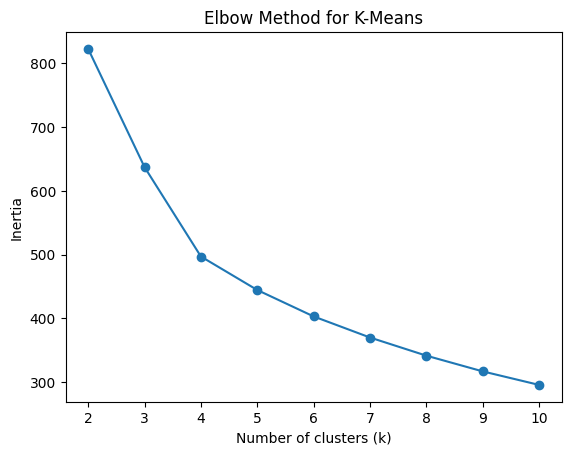

In [16]:
# Plot inertia vs. number of clusters (k) to identify the optimal k using the Elbow Method.
plt.figure()
plt.plot(rfm_results_df['k'], rfm_results_df['inertia'], marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

In [17]:
# Highest Silhouette Score
best_silhouette_idx = rfm_results_df['silhouette_score'].idxmax()
best_silhouette = rfm_results_df.loc[best_silhouette_idx, ['k', 'silhouette_score']]

# Lowest Davies-Bouldin Index
best_dbi_idx = rfm_results_df['davies_bouldin_index'].idxmin()
best_dbi = rfm_results_df.loc[best_dbi_idx, ['k', 'davies_bouldin_index']]

# Highest Calinski-Harabasz Index
best_chi_idx = rfm_results_df['calinski_harabasz_index'].idxmax()
best_chi = rfm_results_df.loc[best_chi_idx, ['k', 'calinski_harabasz_index']]

# Print results
print(f"Best Silhouette Score: {best_silhouette['silhouette_score']:.6f} at k = {best_silhouette['k']}")
print(f"Best Davies-Bouldin Index: {best_dbi['davies_bouldin_index']:.6f} at k = {best_dbi['k']}")
print(f"Best Calinski-Harabasz Index: {best_chi['calinski_harabasz_index']:.6f} at k = {best_chi['k']}")

Best Silhouette Score: 0.325478 at k = 2.0
Best Davies-Bouldin Index: 1.030296 at k = 4.0
Best Calinski-Harabasz Index: 506.671391 at k = 2.0


**Inertia**
- It measures the sum of  squared  distances between each point and its assigned cluster center. It always decreases where there are more clusters.
- Lower inertia is better. This means points are closer to ther cluster center
<br>

**Silhouette Score**
- It measures how similar a point is to its own cluster compared to other clusters, and higher score is better.
- Score close to 1: Good clustering (Clusters are dense and well separated).
- Score around 0.3-0.5: Moderate clustering (Clusters are reasonably distinct, but there is some overlap).
- Score lower than 0.3: Poor clustering (Clusters overlap significantly, which indicates that the chosen number of k is too high or the variables are not well suited for clustering).
<br>

**Davies-Bouldin Index (DBI)**
- It measures how similar each cluster is to its most similar cluster based on the ratio of within-cluster distances to between-cluster distances.
- Lower index (Close to 0) is better. This means clusters are dense and well separated.
<br>

**Calinski-Harabasz Index (CHI)**
- It measures the ratio of between-cluster variance to within-cluster variance.
- Higher index (No upper limit) is better. This means clusters are dense and well separated.

**Interpretation**
- Using the elbow method (inertia), we look for the point where inertia decreases slow down significantly. The biggest drop is between k=2 and k=3, then a moderate drop to k=4 and very small drops after that. Thus, based on the elbow method, k=4.

- Based on Silhouette score, the highest value (0.325478) is at k=2, which provides the best clustering. Then, the second highest vakue (0.2998) is at k=4.

- Based on Davies-Bouldin Index (DBI), the lowest value (1.030296) is at k = 4, which provides the strongest clustering.

- Based on Calinski-Harabasz Index (CHI), the highest value (506.67) is at k=2, which provides the strongest clustering.

- The best k is 4 based on the elbow method and the combination of validation metrics, as k=2 is too simple to capture cluster structure and identify more subtle behaviours.

In [18]:
# Fit final K-Means model using k=4
final_k = 4
kmeans_final = KMeans(n_clusters=final_k, random_state=122, n_init=50)
cluster_labels = kmeans_final.fit_predict(rfm_array)

# Add cluster labels to the original household_profile_df
household_profile_df['cluster'] = cluster_labels + 1

# Display first 5 rows of the dataset
household_profile_df.head(5)

,household_key,age_encoded,income_encoded,household_size_encoded,kid_category_encoded,recency,frequency,monetary,retail_discount_mean,retail_discount_usage_proportion,retail_discount_no_usage_proportion,coupon_discount_mean,coupon_discount_usage_proportion,coupon_discount_no_usage_proportion,did_not_receive_campaign_and_no_coupons_proportion,received_campaign_and_16_coupons_proportion,received_campaign_and_all_coupons_proportion,afternoon_proportion,evening_proportion,midnight_proportion,morning_proportion,night_proportion,displayed_proportion,missing_display_info_proportion,not_displayed_proportion,missing_advertisment_info_proportion,not_on_advertisement_proportion,on_advertisement_proportion,national_proportion,private_proportion,alcohol_proportion,deli & bakery_proportion,entertainment & leisure_proportion,general_grocery_proportion,health_personal_care_proportion,home & lifestyle_proportion,meat_proportion,miscellaneous & services_proportion,produce_proportion,seafood_proportion,inverse_age_encoded,inverse_income_encoded,inverse_household_size_encoded,inverse_kid_category_encoded,inverse_recency,inverse_frequency,inverse_monetary,inverse_retail_discount_mean,inverse_retail_discount_usage_proportion,inverse_retail_discount_no_usage_proportion,inverse_coupon_discount_mean,inverse_coupon_discount_usage_proportion,inverse_coupon_discount_no_usage_proportion,inverse_did_not_receive_campaign_and_no_coupons_proportion,inverse_received_campaign_and_16_coupons_proportion,inverse_received_campaign_and_all_coupons_proportion,inverse_afternoon_proportion,inverse_evening_proportion,inverse_midnight_proportion,inverse_morning_proportion,inverse_night_proportion,inverse_displayed_proportion,inverse_missing_display_info_proportion,inverse_not_displayed_proportion,inverse_missing_advertisment_info_proportion,inverse_not_on_advertisement_proportion,inverse_on_advertisement_proportion,inverse_national_proportion,inverse_private_proportion,inverse_alcohol_proportion,inverse_deli & bakery_proportion,inverse_entertainment & leisure_proportion,inverse_general_grocery_proportion,inverse_health_personal_care_proportion,inverse_home & lifestyle_proportion,inverse_meat_proportion,inverse_miscellaneous & services_proportion,inverse_produce_proportion,inverse_seafood_proportion,cluster
0,1,2.0,-0.333333,0.0,0.0,0.489861,-0.621099,-0.087203,-0.549338,-0.459021,0.459021,1.583771,1.120307,-1.120307,-0.129775,-0.138096,0.078206,1.292766,0.634063,0.139677,1.560290,-3.865000,0.246488,0.393576,-0.913541,0.291299,0.212894,-0.603169,1.501936,-1.501936,0.041404,1.277385,0.053773,0.895717,0.950963,0.090203,0.724057,0.511598,0.932404,-3.621881,65+,35-49K,2,0,5.0,86.0,4330.16,0.403613,0.439490,0.560510,0.015142,0.061378,0.938622,0.549508,0.286624,0.163868,0.612622,0.101911,1.000000e-06,0.285466,1.000000e-06,0.095541,0.830921,0.073538,0.830921,0.054430,0.114650,0.882455,0.117545,1.000000e-06,0.066589,1.000000e-06,0.658944,0.110017,0.000579,0.064852,0.008686,0.090330,1.000000e-06,4
1,7,0.0,0.000000,0.0,0.0,0.000000,-1.136685,-0.358394,-0.737420,-0.420944,0.420944,0.823167,0.572751,-0.572751,0.008514,-0.613512,0.083732,0.365092,0.273008,-0.139884,-0.667486,1.044168,-2.080063,1.423309,0.636160,1.437844,-1.338296,-0.243626,-0.803241,0.803241,-0.068422,0.250714,-0.057319,0.367726,0.847179,0.043339,0.057966,-0.238082,0.445438,-0.495107,45-54,50-74K,2,0,2.0,59.0,3400.05,0.375202,0.444012,0.555988,0.004005,0.020995,0.979005,0.744946,0.122862,0.132193,0.541213,0.330482,1.000000e-06,0.010886,1.174182e-01,0.028771,0.888025,0.083204,0.888025,0.021773,0.090202,0.598756,0.401244,1.000000e-06,0.031882,1.000000e-06,0.645411,0.174183,0.000778,0.048989,0.004666,0.093312,7.776034e-04,4
2,8,-2.0,-0.666667,0.5,1.0,0.489861,-0.263006,0.192638,0.216292,0.127897,-0.127897,0.053112,0.298768,-0.298768,-0.147119,-0.164463,0.093260,-0.190946,0.131973,-0.212785,0.385384,0.814867,0.139347,-0.333988,0.179627,-0.305296,-0.017878,0.288159,0.309949,-0.309949,1.189880,-0.578625,-0.289342,-0.635065,

In [19]:
# Columns of interest for RFM segmentation
rfm_cols_of_interest = ['inverse_frequency', 'inverse_recency', 'inverse_monetary']

# Group by cluster and calculate count, median, and mean
rfm_cluster_summary = household_profile_df.groupby('cluster')[rfm_cols_of_interest] \
    .agg(
        count=('inverse_frequency', 'size'),  # count of rows per cluster
        median_frequency=('inverse_frequency', 'median'),
        mean_frequency=('inverse_frequency', 'mean'),
        median_recency=('inverse_recency', 'median'),
        mean_recency=('inverse_recency', 'mean'),
        median_monetary=('inverse_monetary', 'median'),
        mean_monetary=('inverse_monetary', 'mean')
    )

# Display the summary
rfm_cluster_summary

,count,median_frequency,mean_frequency,median_recency,mean_recency,median_monetary,mean_monetary
cluster,,,,,,,
1,195,122.0,130.835897,1.0,0.758974,3194.170,3446.835333
2,226,158.0,172.371681,5.0,9.765487,5816.680,6292.381947
3,184,279.0,324.277174,0.0,0.711957,9100.755,10035.097717
4,196,80.0,82.668367,8.0,17.760204,2729.005,2842.076888


In [20]:
# Calculate and display the proportion of customers in each cluster to check cluster balance
cluster_proportion = household_profile_df['cluster'].value_counts(normalize=True).sort_index()
print(cluster_proportion)

cluster
1    0.243446
2    0.282147
3    0.229713
4    0.244694
Name: proportion, dtype: float64


The cluster balance looks good because each cluster has about 23-28% of the total customers. No cluster is extremely small or dominating the dtaset.

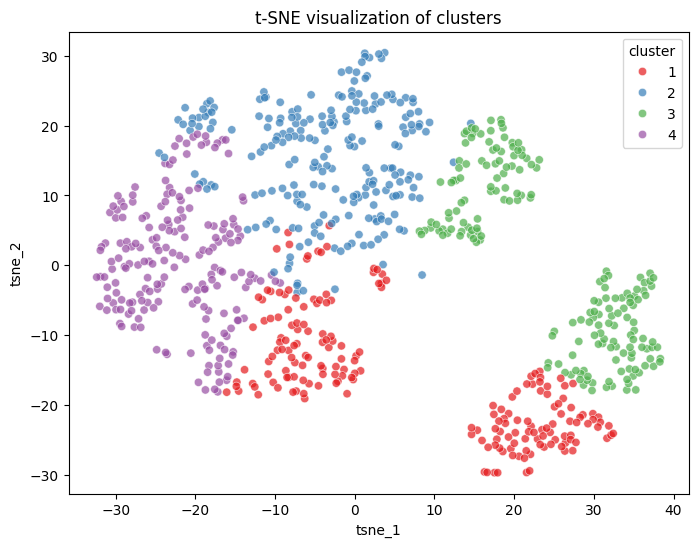

In [21]:
# Select features used for clustering
features = rfm_array

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to DataFrame
household_profile_df['tsne_1'] = tsne_results[:, 0]
household_profile_df['tsne_2'] = tsne_results[:, 1]

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='cluster',
    palette='Set1',
    data=household_profile_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE visualization of clusters')
plt.show()

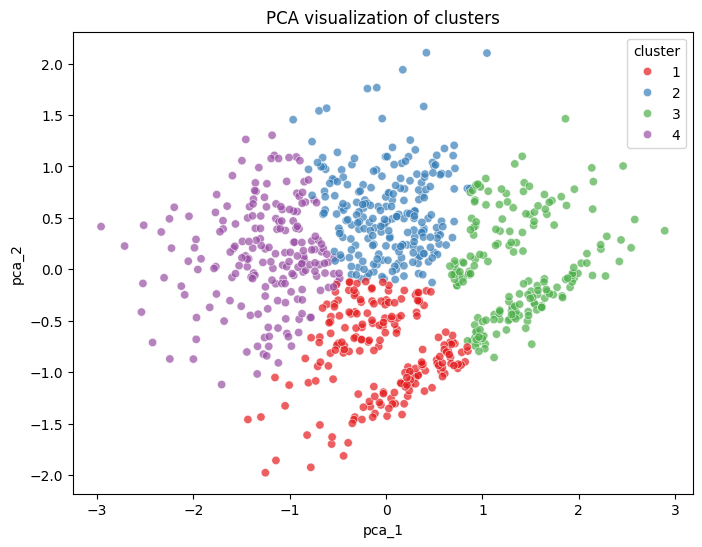

In [24]:
# Select features used for clustering
features = rfm_array

# Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(features)

# Add PCA results to DataFrame
household_profile_df['pca_1'] = pca_results[:, 0]
household_profile_df['pca_2'] = pca_results[:, 1]

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='cluster',
    palette='Set1',
    data=household_profile_df,
    legend='full',
    alpha=0.7
)
plt.title('PCA visualization of clusters')
plt.show()

## Model 2: Hierarchical Clustering

## Model 3: DBSCAN

## Model 4: HDBSCAN

## Model 5: Gaussian Mixture Model

## Model 6: Self Organizing Maps

## Model 7: Support Vector Clustering

## Model 8: Random Forest Clustering

# Hybrid (RFM, Behavioral & Product Preference)

## Model 73: K-Means

## Model 74: Hierarchical Clustering

## Model 75: DBSCAN

## Model 76: HDBSCAN

## Model 77: Gaussian Mixture Model

## Model 78: Self Organizing Maps

## Model 79: Support Vector Clustering

## Model 80: Random Forest Clustering

#